<a href="https://colab.research.google.com/github/dobrotvorn/DataCon23/blob/main/HacatonNotebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Описание задания


## Загрузка данных и библиотек

###Импортируем и скачиваем библиотеки

In [ ]:
!pip install gdown -- quiet
!pip install fancyimpute --quiet
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import plotly
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import KNNImputer
from IPython.display import display, HTML
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from fancyimpute import KNN

ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet


In [ ]:

# тут захардкодим статичные переменные
global ordinal_encoder
global text_columns
global path2firstDb
global path2secondDb
global numerics
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
path2firstDb = '/content/firstDb.csv' if 'google.colab' in sys.modules else 'firstDb.csv'
path2secondDb = '/content/secondDb.csv' if 'google.colab' in sys.modules else 'secondDb.csv'

### Скачиваем данные

In [ ]:
url1 = 'https://drive.google.com/uc?id=1-3ErIGqYlM-4gC39Mzv1-wlFVGhN80UH'
url2 = 'https://drive.google.com/uc?id=1-EsWBtWMMc-zO1gxxj7JcJV7en5uwheU'
utl_extra = 'https://drive.google.com/uc?id=1T2V4SUncM57yFjym-Z_tFkyUSanP1i09'
output1 = 'firstDb.csv'
output2 = 'secondDb.csv'
output_extra = 'extra.xlsx'
gdown.download(url1, output1, quiet=True)
gdown.download(url2, output2, quiet=True)
gdown.download(utl_extra, output_extra, quiet=True)

'extra.xlsx'

## Обработка данных

In [ ]:
fdb = pd.read_csv(path2firstDb)
fdb.head(7)

,Unnamed: 0,Nanoparticle,Type: Organic (O)/inorganic (I),coat,Diameter (nm),Concentration μM,Zeta potential (mV),Cells,Cell line (L)/primary cells (P),Human(H)/Animal(A) cells,"Cell age: embryonic (E), Adult (A)",Exposure time (h),% Cell viability
0,9,CuO,I,NaN,52.51,3.471326e-05,-39.67,A549,L,H,A,24,74.587160
1,10,CuO,I,NaN,52.51,8.678315e-05,-39.67,A549,L,H,A,24,66.055046
2,11,CuO,I,NaN,52.51,1.735663e-04,-39.67,A549,L,H,A,24,48.165140
3,12,CuO,I,NaN,52.51,3.471326e-05,-39.67,A549,L,H,A,24,84.713870
4,13,CuO,I,NaN,52.51,8.678315e-05,-39.67,A549,L,H,A,24,68.672810
5,14,CuO,I,NaN,52.51,1.735663e-04,-39.67,A549,L,H,A,24,45.379680
6,15,CuO,I,NaN,239.00,3.681525e-31,NaN,HCMEC,P,H,A,12,98.876400


In [ ]:
# Сразу же видим выброс в 6й строчке -> обработаем:
fdb.iloc[6,5] = fdb.iloc[6,5]* 10 ** 20

In [ ]:
sdb = pd.read_csv(path2secondDb)
sdb.head(3)

,Unnamed: 0,No,Year,Material,Type,Coat,Surface_Charge,Diameter (nm),Cell_Type,Human_Animal,Cell_Age,Cell Line_Primary Cell,Time (hr),Concentration (ug/ml),Cell_Viability (%),DOI
0,92,93,2014,IronOxide,I,Dextran,unknown,18.0,VERO,A,Adult,L,24,100.0,102.00,10.1002/jbm.b.33068
1,93,94,2014,IronOxide,I,Dextran,unknown,18.0,VERO,A,Adult,L,24,200.0,105.08,10.1002/jbm.b.33068
2,94,95,2014,IronOxide,I,Dextran,unknown,18.0,VERO,A,Adult,L,24,300.0,100.00,10.1002/jbm.b.33068


In [ ]:
# также удалим еще один выброс, где coat = unknown
sdb= sdb.drop(index=1053)

Посмотрим на пару семплов из разных статей - почитаем, действительно ли там то, о чем написано в статьях
- (дисклеймер - вроде, да)

In [ ]:
pd.concat([sdb[sdb.DOI=='10.1007/s11051-018-4406-0'].head(1),sdb[sdb.DOI=='10.1002/smll.201502346'].head(1)], axis=0)

,Unnamed: 0,No,Year,Material,Type,Coat,Surface_Charge,Diameter (nm),Cell_Type,Human_Animal,Cell_Age,Cell Line_Primary Cell,Time (hr),Concentration (ug/ml),Cell_Viability (%),DOI
668,2231,2232,2018,Au,I,Citrate,Negative,14.5,PBMC,H,Adult,P,24,15.0,71.030,10.1007/s11051-018-4406-0
411,1486,1487,2015,Au,I,MSA,Negative,1.5,WA09,H,Embryonic,L,24,10.0,15.174,10.1002/smll.201502346


In [ ]:
#заменим остальные пропуски в данных на None, потому что каких-то больших смыслов не обнаружено (за исключением Surface_Charge, но там пришли к мнению, что нейтральный - это 0)
none_mapper = { '-': np.nan, 'None': np.nan, None: np.nan}
sdb.replace(none_mapper, inplace=True)
fdb.replace(none_mapper, inplace=True)

# для coat пришли к мнению, что тамЮ где Null, там просто немодифицированная частица -> так ее и назовем
fdb['coat'] = fdb['coat'].fillna('NotModified')
sdb['Coat'] = sdb['Coat'].fillna('NotModified')

sdb.replace({'unknown': np.nan}, inplace=True)
fdb.replace({'unknown': np.nan}, inplace=True)



In [ ]:
sdb.Surface_Charge.unique()

array([nan, 'Positive', 'Negative', 'Neutral'], dtype=object)

In [ ]:
sdb['Coat'].isnull().sum()
# sdb['Coat'].unique()

0

Изменим данные из 1й базы данных так, чтобы их можно было присоединить к данным из второй базы данных. Из второй базы данных удалим лишние столбцы (год, номер, DOI)

In [ ]:
# Переименуем столбцы в первой бд, чтобы присоединить ее ко второй
fdb = fdb.rename(columns=
                 {'Nanoparticle': 'Material',
                'Zeta potential (mV)': 'Surface_Charge',
                'Cells': 'Cell_Type',
                'Cell line (L)/primary cells (P)': 'Cell Line_Primary Cell',
                'Human(H)/Animal(A) cells': 'Human_Animal',
                'Exposure time (h)': 'Time (hr)',
                'Type: Organic (O)/inorganic (I)': 'Type',
                'coat': 'Coat',
                '% Cell viability': 'Cell_Viability (%)'}
)
# Приведем все к одним единицам измерения

# Приведем молярные массы
hardcode_mol_mass = {'CuO' : 79.53, 'Iron oxide': 215.49,'IronOxide':215.49,'IronOide':215.49 ,'Au':196.96, 'Cu2O':143.07}
fdb['Concentration (ug/ml)']= fdb[['Concentration μM', 'Material' ]].apply(lambda x:  hardcode_mol_mass[x['Material']] * float(x['Concentration μM']/ 1000 if x['Material'] and x['Concentration μM']  else None), axis=1)

# Приведем обозначения возраста
hardcode_age = {'E' : 'Embryonic', 'A' : 'Adult', 'F': 'Fetus'}
fdb['Cell_Age'] = fdb['Cell age: embryonic (E), Adult (A)'].apply(lambda x: hardcode_age[x] if x else np.nan)

#Приведем значения зарада - тут получилось, что во второй базе известно только положительный или отрицательный, хотя для задаче важно больше 30 по модулю или нет. В этом может быть проблема
fdb['Surface_Charge'] = fdb['Surface_Charge'].apply(lambda x: 'Positive' if float(x) > 0 else 'Negative' if float(x) < 0 else 'Neutral' if float(x) == 0 else np.nan)

# Переведем во float то, что не перевелось во float из-за '-'
fdb['Concentration (ug/ml)'] = fdb['Concentration (ug/ml)'].astype(float)
sdb['Concentration (ug/ml)'] = sdb['Concentration (ug/ml)'].astype(float)

fdb['Diameter (nm)'] = fdb['Diameter (nm)'].astype(float)
sdb['Diameter (nm)'] = sdb['Diameter (nm)'].astype(float)


#удалим ненужные столбцы
fdb_new = fdb.drop(columns=['Concentration μM', 'Cell age: embryonic (E), Adult (A)'])
sdb_new = sdb.drop(columns=['No','Year', 'DOI'], axis=1)
fdb_new.head(2) # вот такая получилась первая бд после обработки

,Unnamed: 0,Material,Type,Coat,Diameter (nm),Surface_Charge,Cell_Type,Cell Line_Primary Cell,Human_Animal,Time (hr),Cell_Viability (%),Concentration (ug/ml),Cell_Age
0,9,CuO,I,NotModified,52.51,Negative,A549,L,H,24,74.587160,0.000003,Adult
1,10,CuO,I,NotModified,52.51,Negative,A549,L,H,24,66.055046,0.000007,Adult


In [ ]:
fdb_new[fdb_new['Cell_Viability (%)'] == 100.75949]  # тут проводим какие-то эксперименты с концентрацией

,Unnamed: 0,Material,Type,Coat,Diameter (nm),Surface_Charge,Cell_Type,Cell Line_Primary Cell,Human_Animal,Time (hr),Cell_Viability (%),Concentration (ug/ml),Cell_Age
760,1959,Au,I,NotModified,20.0,NaN,HEK­293,L,H,48,100.75949,0.000197,Embryonic


Итак, объединяем все в один файл, как видим, у нас еще остались пропуски в данных. Уберем их и сохраним готовый файл на диск!)

In [ ]:
df = pd.concat([fdb_new, sdb_new], axis=0)
df.isnull().any()

Unnamed: 0                False
Material                  False
Type                      False
Coat                      False
Diameter (nm)              True
Surface_Charge             True
Cell_Type                 False
Cell Line_Primary Cell    False
Human_Animal              False
Time (hr)                 False
Cell_Viability (%)        False
Concentration (ug/ml)      True
Cell_Age                  False
dtype: bool

In [ ]:
df.Surface_Charge.unique()

array(['Negative', nan, 'Positive', 'Neutral'], dtype=object)

In [ ]:
df

,Unnamed: 0,Material,Type,Coat,Diameter (nm),Surface_Charge,Cell_Type,Cell Line_Primary Cell,Human_Animal,Time (hr),Cell_Viability (%),Concentration (ug/ml),Cell_Age
0,9,CuO,I,NotModified,52.51,Negative,A549,L,H,24,74.587160,0.000003,Adult
1,10,CuO,I,NotModified,52.51,Negative,A549,L,H,24,66.055046,0.000007,Adult
2,11,CuO,I,NotModified,52.51,Negative,A549,L,H,24,48.165140,0.000014,Adult
3,12,CuO,I,NotModified,52.51,Negative,A549,L,H,24,84.713870,0.000003,Adult
4,13,CuO,I,NotModified,52.51,Negative,A549,L,H,24,68.672810,0.000007,Adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,3811,Au,I,Citrate,4.70,Negative,RAW264.7,L,A,48,68.957000,100.000000,Adult
1060,3816,Au,I,Citrate,270.00,Negative,RAW264.7,L,A,48,93.893000,5.000000,Adult
1061,3817,Au,I,Citrate,270.00,Negative,RAW264.7,L,A,48,86.005000,10.000000,Adult
1062,3818,Au,I,Citrate,270.00,Negative,RAW264.7,L,A,48,79.644000,100.000000,Adult


In [ ]:
# проверяем, какие стобцы нужны, как они называются
# проверяем на совместимость единиц измерения
# соединяем таблицы
# предобрабатываем числовые и нечисловые признаки
# отдельно прописываем, какие столбцы числовые, какие порядковые, а какие numerical

Посмотрим, сколько уникальных значений есть в столбцах в базах данных

In [ ]:
# Create HTML representations of the dataframes
html1 = pd.DataFrame(sdb.nunique(), columns=['second Db unique values']).to_html()
html2 = pd.DataFrame(fdb.nunique(), columns=['first Db unique values']).to_html()

# Concatenate the HTML strings side by side
html = '<table><tr><td>{}</td><td>{}</td></tr></table>'.format(html1, html2)

# Display the concatenated HTML
display(HTML(html))


,second Db unique values
Unnamed: 0,1063
No,1063
Year,11
Material,4
Type,1
Coat,20
Surface_Charge,3
Diameter (nm),59
Cell_Type,46
Human_Animal,2


Посмотрим на численные переменные, увидим выбросы, сравнив мин и макс с 1 и 99 перцентилем

In [ ]:
sdb.describe(percentiles=[.99, .01])

,Unnamed: 0,No,Year,Diameter (nm),Time (hr),Concentration (ug/ml),Cell_Viability (%)
count,1063.000000,1063.000000,1063.000000,949.000000,1063.000000,951.000000,1063.000000
mean,1869.347131,1870.347131,2015.754468,34.839136,32.374412,54.588238,79.436838
std,976.055597,976.055597,2.644490,45.852402,21.697305,102.737517,30.770926
min,92.000000,93.000000,2010.000000,1.500000,3.000000,0.001000,-1.398600
1%,102.620000,103.620000,2010.000000,1.500000,3.000000,0.010000,1.212100
50%,1622.000000,1623.000000,2016.000000,18.000000,24.000000,10.000000,88.629000
99%,3794.760000,3795.760000,2020.000000,215.000000,96.000000,400.000000,128.290800
max,3819.000000,3820.000000,2020.000000,270.000000,96.000000,1000.000000,234.630000


Заполним пропуски

In [ ]:
# разделим на категориальный и числовые

text_columns = df.select_dtypes(include='object').columns.tolist()

numeric_columns = df.select_dtypes(include=numerics).columns.tolist()

In [ ]:
df[text_columns].head(3) # Пример категориальных

,Material,Type,Coat,Surface_Charge,Cell_Type,Cell Line_Primary Cell,Human_Animal,Cell_Age
0,CuO,I,NotModified,Negative,A549,L,H,Adult
1,CuO,I,NotModified,Negative,A549,L,H,Adult
2,CuO,I,NotModified,Negative,A549,L,H,Adult


In [ ]:
df['Coat'].isnull().sum()

0

In [ ]:

from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin

# def replace_unknown(x):
#     none_mapper = {'unknown': None, '-': None, 'None': None}
#     return x.replace(none_mapper)

# Custom transformer to invert the label encoding
def convert_to_int(X):
    X= X.round().astype(np.float64) # Change columns 2 and 4 to int
    return X

int_converter = FunctionTransformer(convert_to_int)

class OrdinalDecoder(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return ordinal_encoder.inverse_transform(X)

    def fit_transform(self, X, y=None):
        return ordinal_encoder.inverse_transform(X)

    def get_feature_names_out(self, *args, **params):
        return text_columns


ordinal_encoder = OrdinalEncoder(encoded_missing_value=-100)
ordinal_encoder.fit(df[text_columns])
# print('1   ', ordinal_encoder.categories_) # запустив эту строчку,
# можно посмотреть на то, какие переменные закодированы
ordinal_decoder = OrdinalDecoder()
numerical_transformer = Pipeline(
    steps=[

          ('label_encoder', ordinal_encoder),
          ('imputer', KNNImputer(missing_values=-100, n_neighbors=5)), # находим самые похожие семплы и определяем пропущенное значение как среднее в этих семплах
          ('type_conversion', int_converter),
          ('label_decoder',  OrdinalDecoder())
        # ('encoder', OneHotEncoder()),
        # ('scaler', StandardScaler())
    ]
)

ratio_transformer = Pipeline(
    steps=[
          ('imputer', KNNImputer(n_neighbors=50)),
        # ('imputer', IterativeImputer(random_state=0)),

        # ('encoder', OneHotEncoder()),
        # ('scaler', RobustScaler())
    ]
)


column_transformer = ColumnTransformer([
    # ('replace unknown with none', FunctionTransformer(replace_unknown), df.columns),
    ('c',numerical_transformer, text_columns),
    ('r',ratio_transformer, numeric_columns),
]
)
column_transformer.set_output(transform='pandas') # вот такой трансформер получился

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


ColumnTransformer(transformers=[('c',
                                 Pipeline(steps=[('label_encoder',
                                                  OrdinalEncoder(encoded_missing_value=-100)),
                                                 ('imputer',
                                                  KNNImputer(missing_values=-100)),
                                                 ('type_conversion',
                                                  FunctionTransformer(func=<function convert_to_int at 0x7fd1e3ea0c10>)),
                                                 ('label_decoder',
                                                  OrdinalDecoder())]),
                                 ['Material', 'Type', 'Coat', 'Surface_Charge',
                                  'Cell_Type', 'Cell Line_Primary Cell',
                                  'Human_Animal', 'Cell_Age']),
                                ('r',
                                 Pipeline(steps=[('imputer',
                                                  KNNImputer(n_neighbors=50))]),
                                 ['Unnamed: 0', 'Diameter (nm)', 'Time (hr)',
                                  'Cell_Viability (%)',
                                  'Concentration (ug/ml)'])])

In [ ]:
data_transformed = column_transformer.fit_transform(df)
print('Пропуски есть' if data_transformed.isnull().any().any() else 'Пропусков нет!)')

Пропусков нет!)


In [ ]:
# data_transformed.to_csv('clear_data_first_minitask.csv')
# data_transformed.isnull().any() # аналитика на случай, если они все-таки появятся

In [ ]:
# data_transformed[data_transformed['c__Surface_Charge'].isnull()]

In [ ]:
for i in data_transformed['c__Surface_Charge'].unique():
  print(i, ' ', (data_transformed['c__Surface_Charge'] == i).sum())

Negative   1161
Positive   661
Neutral   48


Тут меняем названия в coat

In [ ]:
data_transformed.c__Coat[data_transformed.c__Coat =='OleicAcid'] = 'Oleic Acid'

<ipython-input-525-8d9dd1f94650>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_transformed.c__Coat[data_transformed.c__Coat =='OleicAcid'] = 'Oleic Acid'


In [ ]:
data_transformed.head(5)

,c__Material,c__Type,c__Coat,c__Surface_Charge,c__Cell_Type,c__Cell Line_Primary Cell,c__Human_Animal,c__Cell_Age,r__Unnamed: 0,r__Diameter (nm),r__Time (hr),r__Cell_Viability (%),r__Concentration (ug/ml)
0,CuO,I,NotModified,Negative,A549,L,H,Adult,9.0,52.51,24.0,74.587160,0.000003
1,CuO,I,NotModified,Negative,A549,L,H,Adult,10.0,52.51,24.0,66.055046,0.000007
2,CuO,I,NotModified,Negative,A549,L,H,Adult,11.0,52.51,24.0,48.165140,0.000014
3,CuO,I,NotModified,Negative,A549,L,H,Adult,12.0,52.51,24.0,84.713870,0.000003
4,CuO,I,NotModified,Negative,A549,L,H,Adult,13.0,52.51,24.0,68.672810,0.000007


### Добавим дополнительную информацию (extra)

In [ ]:
extra_data = pd.read_excel(output_extra)
full_data = data_transformed.merge(extra_data, how='left', left_on='c__Coat', right_on='Столбец coat, файл 1').drop('Столбец coat, файл 1', axis=1)
full_data.replace(none_mapper, inplace=True)
full_data.head()

,c__Material,c__Type,c__Coat,c__Surface_Charge,c__Cell_Type,c__Cell Line_Primary Cell,c__Human_Animal,c__Cell_Age,r__Unnamed: 0,r__Diameter (nm),r__Time (hr),r__Cell_Viability (%),r__Concentration (ug/ml),Формула мономера,SMILES,Log P мономера,Предполагаемый заряд поверхности
0,CuO,I,NotModified,Negative,A549,L,H,Adult,9.0,52.51,24.0,74.587160,0.000003,no,no,0.0,no
1,CuO,I,NotModified,Negative,A549,L,H,Adult,10.0,52.51,24.0,66.055046,0.000007,no,no,0.0,no
2,CuO,I,NotModified,Negative,A549,L,H,Adult,11.0,52.51,24.0,48.165140,0.000014,no,no,0.0,no
3,CuO,I,NotModified,Negative,A549,L,H,Adult,12.0,52.51,24.0,84.713870,0.000003,no,no,0.0,no
4,CuO,I,NotModified,Negative,A549,L,H,Adult,13.0,52.51,24.0,68.672810,0.000007,no,no,0.0,no


Тут тоже меняем названия, главное, что это произошло после merge

In [ ]:
data_transformed.c__Coat[data_transformed.c__Coat =='COOH'] = 'PEG-COOH'
data_transformed.c__Coat[data_transformed.c__Coat =='NH2'] = 'PEG-NH2'
data_transformed.c__Coat[data_transformed.c__Coat =='Sodium borohydride'] = 'NotModified'
data_transformed.c__Coat[data_transformed.c__Coat =='Star anise'] = 'Primary Products'
data_transformed.c__Coat[data_transformed.c__Coat =='Gum Arabic'] = 'Primary Products'
data_transformed.c__Coat[data_transformed.c__Coat =='dimercaptosuccinic'] = 'DMSA'

full_data.c__Coat[full_data.c__Coat =='COOH'] = 'PEG-COOH'
full_data.c__Coat[full_data.c__Coat =='NH2'] = 'PEG-NH2'
full_data.c__Coat[full_data.c__Coat =='Sodium borohydride'] = 'NotModified'
full_data.c__Coat[full_data.c__Coat =='Star anise'] = 'Primary Products'
full_data.c__Coat[full_data.c__Coat =='Gum Arabic'] = 'Primary Products'
full_data.c__Coat[full_data.c__Coat =='dimercaptosuccinic'] = 'DMSA'

hardcode_ferrum = {'Iron Oxide':'Fe3O4', 'IronOxide' : 'Fe3O4', 'IronOide' :'Fe3O4', 'Iron oxide' : 'Fe3O4'}
data_transformed['c__Material'] = data_transformed['c__Material'].apply(lambda x: hardcode_ferrum[x] if x in hardcode_ferrum else x)
full_data['c__Material'] = full_data['c__Material'].apply(lambda x: hardcode_ferrum[x] if x in hardcode_ferrum else x)

<ipython-input-528-885c9b4db97e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_transformed.c__Coat[data_transformed.c__Coat =='COOH'] = 'PEG-COOH'
<ipython-input-528-885c9b4db97e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_transformed.c__Coat[data_transformed.c__Coat =='NH2'] = 'PEG-NH2'
<ipython-input-528-885c9b4db97e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_transformed.c__Coat[data_transformed.c__Coat

In [ ]:
# Проверка на то, что все стобцы совпали по наваниям для правильного джойна - Дисклеймер, все окей
# a = list(extra_data['Столбец coat, файл 1'].sort_values())
# b = list(sorted(data_transformed['c__Coat'].unique()))

# print(pd.DataFrame({'new':a, 'old' :b}))
full_data.loc[full_data['Log P мономера'][full_data['Log P мономера'].isnull()].index]

,c__Material,c__Type,c__Coat,c__Surface_Charge,c__Cell_Type,c__Cell Line_Primary Cell,c__Human_Animal,c__Cell_Age,r__Unnamed: 0,r__Diameter (nm),r__Time (hr),r__Cell_Viability (%),r__Concentration (ug/ml),Формула мономера,SMILES,Log P мономера,Предполагаемый заряд поверхности


In [ ]:
full_data.isnull().sum()

c__Material                         0
c__Type                             0
c__Coat                             0
c__Surface_Charge                   0
c__Cell_Type                        0
c__Cell Line_Primary Cell           0
c__Human_Animal                     0
c__Cell_Age                         0
r__Unnamed: 0                       0
r__Diameter (nm)                    0
r__Time (hr)                        0
r__Cell_Viability (%)               0
r__Concentration (ug/ml)            0
Формула мономера                    0
SMILES                              0
Log P мономера                      0
Предполагаемый заряд поверхности    0
dtype: int64

In [ ]:
full_data.c__Material.unique()

array(['CuO', 'Fe3O4', 'Cu2O', 'Au'], dtype=object)

In [ ]:
full_data.drop(columns = ['c__Type', 'r__Concentration (ug/ml)'],axis = 1, inplace=True)

In [ ]:
full_data.to_csv('clear_data_first_minitask.csv')

## Визуализация данных

In [ ]:
# Алгоритм
# строим график (с описанием, легендой и темой крутой)
# делаем аналитическое описание того, что видим
# сохраняем график
display(text_columns,numeric_columns)

['Material',
 'Type',
 'Coat',
 'Surface_Charge',
 'Cell_Type',
 'Cell Line_Primary Cell',
 'Human_Animal',
 'Cell_Age']

['Unnamed: 0',
 'Diameter (nm)',
 'Time (hr)',
 'Cell_Viability (%)',
 'Concentration (ug/ml)']

Text(0.5, 1.0, 'Обзорное попарное сравнение всех фич со всеми и гистограммы для каждой фичи в отдельности.')

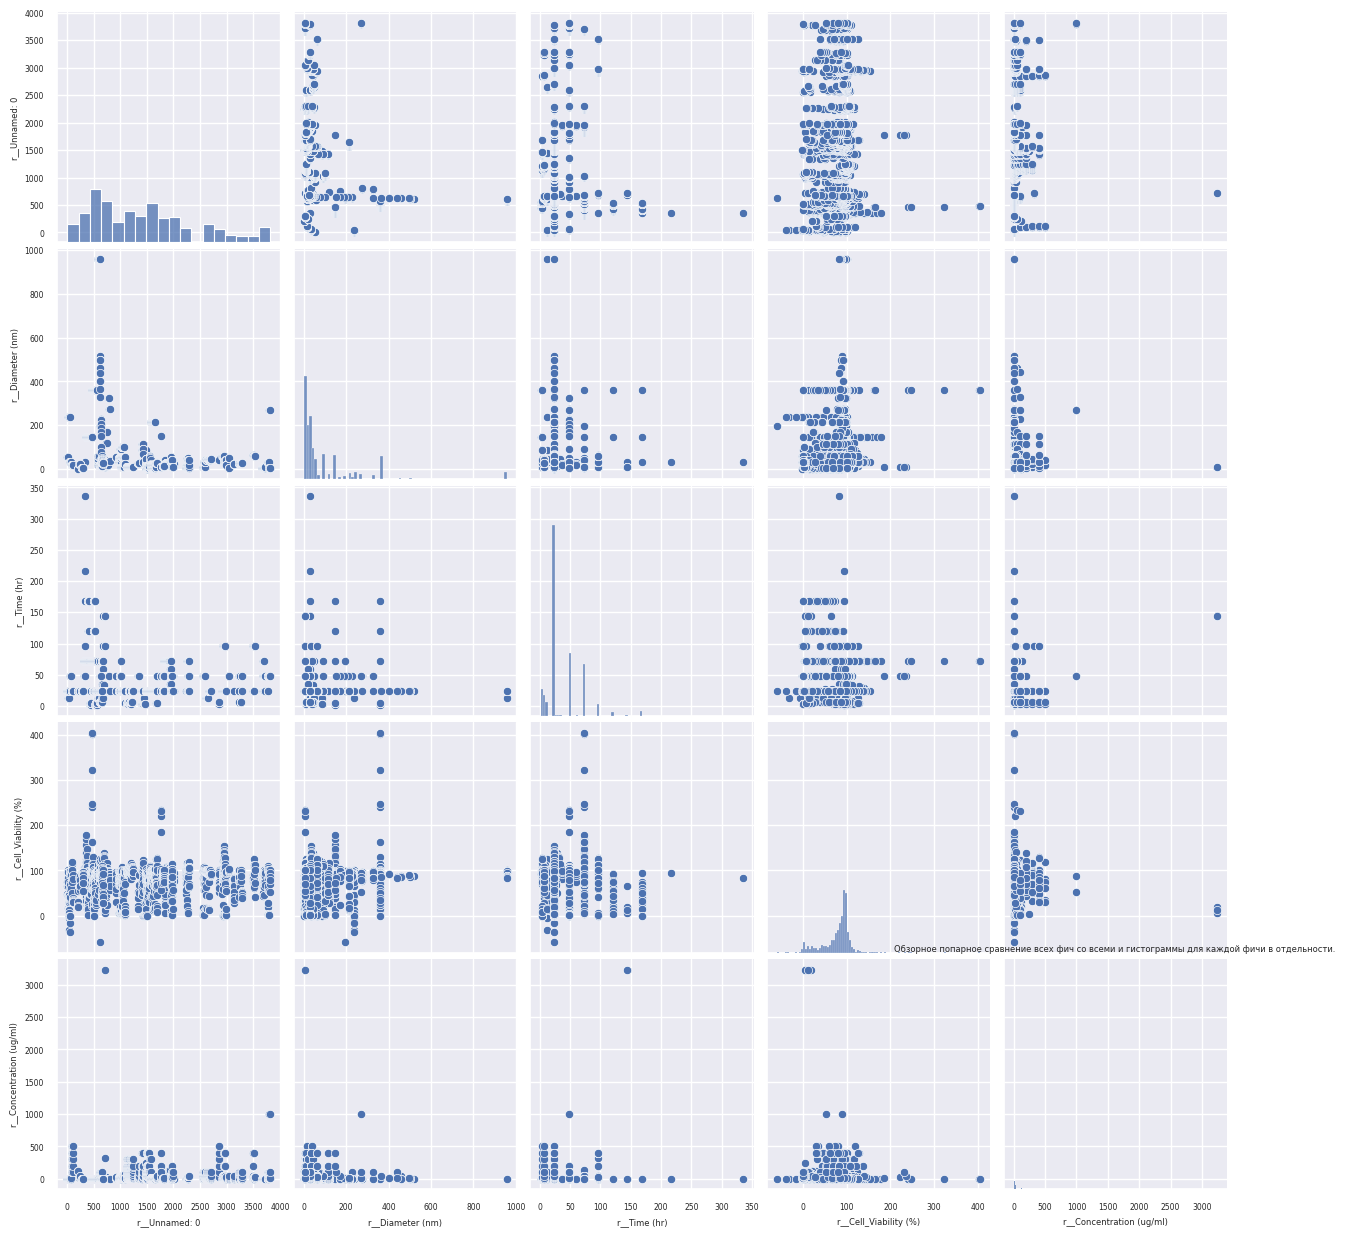

In [ ]:
sns.pairplot(data_transformed)
plt.title('Обзорное попарное сравнение всех фич со всеми и гистограммы для каждой фичи в отдельности.')

Text(0.5, 1.0, 'Влияние поверхностного заряда наночастиц на выживаемость клеток')

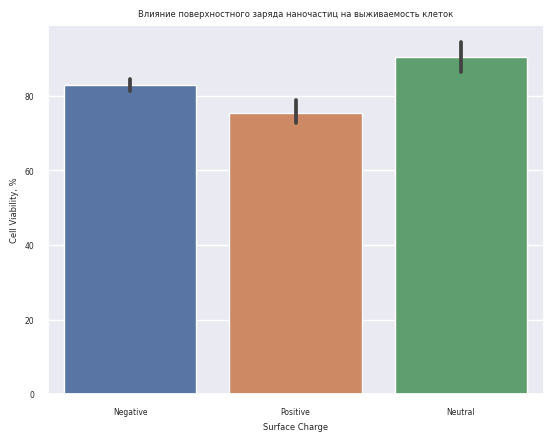

In [ ]:
ax = sns.barplot(x = 'c__Surface_Charge', y = 'r__Cell_Viability (%)', data = full_data);
ax.set(xlabel='Surface Charge', ylabel='Cell Viability, %')
plt.title('Влияние поверхностного заряда наночастиц на выживаемость клеток')

In [ ]:
#Не нужный график
#ax = sns.barplot(x = 'Предполагаемый заряд поверхности', y = 'r__Cell_Viability (%)', data = full_data);
#ax.set(xlabel='Surface Charge', ylabel='Cell Viability, %')
#plt.title('Влияние поверхностного заряда наночастиц на выживаемость клеток')

<ipython-input-538-81c26c6257f6>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=data_transformed, y="c__Coat", x="r__Cell_Viability (%)", ci=None, order=order)


Text(0.5, 1.0, 'Влияние покрытия наночастиц на выживаемость клеток')

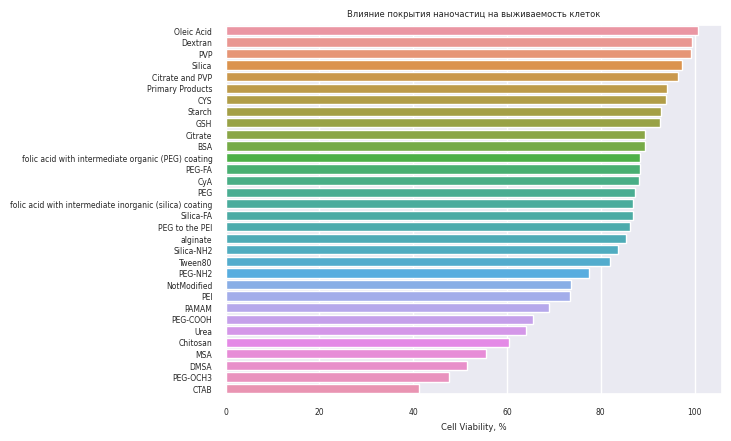

In [ ]:
order = data_transformed.groupby(["c__Coat"])["r__Cell_Viability (%)"].mean().sort_values(ascending=False).index
ax = sns.barplot(data=data_transformed, y="c__Coat", x="r__Cell_Viability (%)", ci=None, order=order)
ax.set(ylabel='', xlabel='Cell Viability, %')
sns.set (font_scale=0.5)
plt.title('Влияние покрытия наночастиц на выживаемость клеток')

<ipython-input-539-ffaf66c0f103>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=data_transformed, x="r__Time (hr)", y="r__Cell_Viability (%)", ci=None)


Text(0.5, 1.0, 'Влияние времени экспозиции наночастиц на выживаемость клеток')

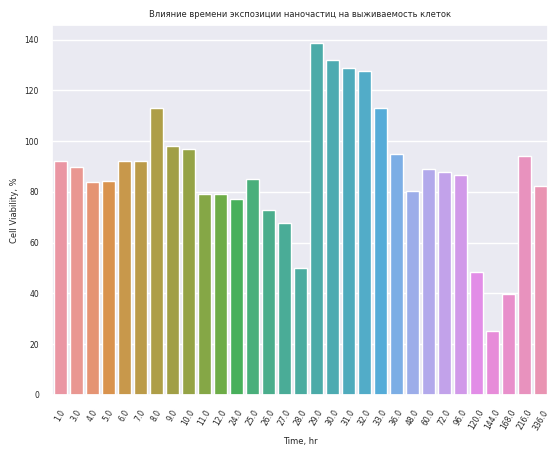

In [ ]:
ax = sns.barplot(data=data_transformed, x="r__Time (hr)", y="r__Cell_Viability (%)", ci=None)
ax.set(xlabel='Time, hr', ylabel='Cell Viability, %')
ax.tick_params(axis='x', rotation=60)
plt.title('Влияние времени экспозиции наночастиц на выживаемость клеток')

Text(0.5, 1.0, 'Влияние матрицы наночастиц на выживаемость клеток')

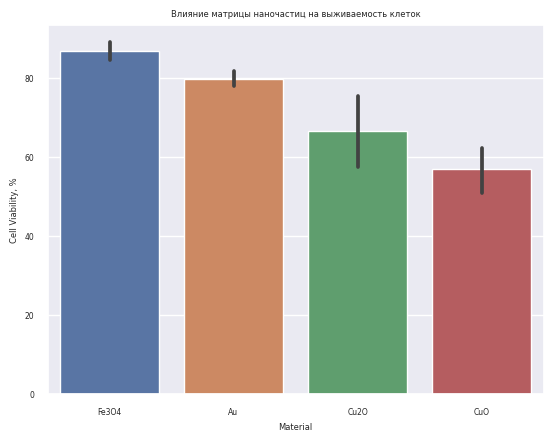

In [ ]:
order = data_transformed.groupby(["c__Material"])["r__Cell_Viability (%)"].mean().sort_values(ascending=False).index
ax = sns.barplot(data=data_transformed, x="c__Material", y="r__Cell_Viability (%)", order=order)
ax.set(xlabel='Material', ylabel='Cell Viability, %')
plt.title('Влияние матрицы наночастиц на выживаемость клеток')

<ipython-input-541-31015d45a13a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_transformed.corr()
<ipython-input-541-31015d45a13a>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<Axes: >

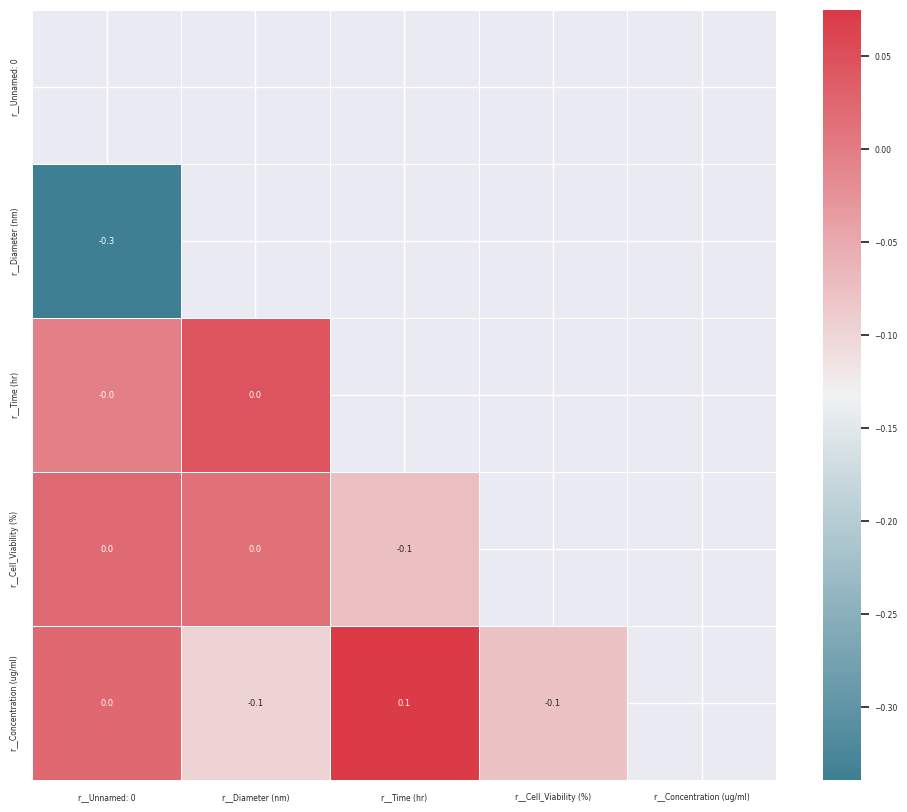

In [ ]:
#Пускай временно повисит тут, потом будем разбираться что тут да как
corr = data_transformed.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, linewidths=.5, mask=mask,annot=True, fmt='.1f')

Вывод по двум столбчатым диаграммам выше:

*    Жизнеспособность (%) оказывается статистически ниже при положительном заряде наночастицы и её покрытия.

## Разведочный анализ данных (опционально)

### Кластеризация

In [ ]:
# тут можем скластеризовать как-то семплы, с помощью PCA, DBscan
# можно попробовать импортировать трансформер, преобразовать текстовые признаки в вестора и тоже откластеризовать
# можно как-то попробовать чат джпт прикрутить, но это уже из области 'ищу то, не знаю, что'

## описание признаков сегенерированное с помощью ChatGPT 4.0


Описание:
1.   Material type, nanoparticle - химическая формула: Химическая формула наноматериала может влиять на его токсичность в зависимости от взаимодействия с клетками и биологическими процессами.

2.  Elements - некислородный элемент входящий в состав: Различные некислородные элементы могут иметь различные токсичные свойства и взаимодействовать с клетками по-разному.

3.  Electronegativity - электроотрицательность по Полингу: Высокая электроотрицательность наноматериала может способствовать его токсичности путем возможного образования реактивных кислородных и азотистых видов, которые могут повредить клетки.

4.  Ionic radius - ионный радиус элемента: Ионный радиус элемента может влиять на его способность вступать во взаимодействие с клетками и внедряться в них, что может повлиять на токсичность наноматериала.

5. Core size - размер кристаллита: Размер кристаллита наноматериала может влиять на его поверхностную активность и способность взаимодействовать с клетками, что может влиять на его токсичность.

6. Hydro size, diameter - гидродинамический диаметр частиц: Гидродинамический диаметр частиц определяет их поведение в растворе и способность проникать в клетки, что может влиять на их токсичность.

7. Surface charge, zeta potential - дзета-потенциал или заряд поверхности: Заряд поверхности наноматериала может влиять на его взаимодействие с клетками, а также на его устойчивость в растворе, что может отразиться на токсичности.

8. Surface area - площадь поверхности материала: Большая площадь поверхности может увеличить взаимодействие наноматериала с клетками и повысить его токсичность.

9. Cell type, cells: Тип клеток может влиять на токсичность наноматериала, поскольку различные типы клеток могут иметь разную чувствительность к разным веществам. Некоторые клеточные линии могут быть более чувствительными к наноматериалам, чем другие, и могут проявлять более выраженные токсические эффекты.

10. Exposure dose, concentration, dose: Финальная концентрация наноматериала в растворе с клетками может оказывать влияние на его токсичность. Высокие концентрации наноматериала могут привести к усилению токсических эффектов, в то время как более низкие концентрации могут оказывать менее выраженное воздействие.

11. Number of atoms: Количество атомов в наноматериале может влиять на его токсичность. Более крупные наночастицы с большим количеством атомов могут иметь более выраженные токсические свойства, поскольку большее количество вещества может взаимодействовать с клетками.

12. Molecular weight: Молекулярный вес наноматериала может влиять на его токсичность. Более тяжелые наноматериалы могут иметь более выраженные токсические свойства, поскольку они могут быть более сложными для обработки клетками и могут вызывать более сильные воздействия на биологические процессы.

13. Topological polar surface area: Топологическая полярная площадь поверхности наноматериала может влиять на его токсичность. Большая полярная поверхность может увеличить взаимодействие наноматериала с биологическими молекулами и клетками, что может привести к более выраженным токсическим эффектам.

14. a, b, c, alpha, beta, gamma: Параметры кристаллической решетки наноматериала могут влиять на его токсичность. Кристаллическая структура может определять взаимодействие наноматериала с клетками и биологическими процессами, что в свою очередь может влиять на его токсические свойства.

15. Density: Плотность наноматериала может влиять на его токсичность. Более плотные материалы могут обладать более высокой степенью взаимодействия с клетками и биологическими структурами, что может привести к более выраженным токсическим эффектам.

16. Viability: Выживаемость клеток может быть важным показателем токсичности наноматериала. Снижение выживаемости клеток после воздействия наноматериала может указывать на его токсическое действие и потенциальную вредность для живых систем.

17. Type: Тип наноматериала (органический или неорганический) может оказывать влияние на его токсичность. Различные типы материалов могут иметь разные химические свойства и способность взаимодействовать с клетками, что может влиять на степень их токсичности.

18. Coat: Поверхностная модификация наноматериала может влиять на его токсичность. Различные покрытия или модификации поверхности могут изменить взаимодействие наноматериала с клетками и биологическими системами, что может привести к изменению его токсических свойств.

19. Cell line / primary cells: Тип клеточной линии или использование первичных клеток может влиять на токсичность наноматериала. Разные типы клеток могут иметь разную чувствительность к наноматериалам и проявлять разные реакции на их воздействие.

20. Human / animal: Человеческие и животные клетки могут отличаться по своей чувствительности к наноматериалам. Таким образом, токсичность наноматериала может различаться в зависимости от типа клеток, используемых для исследования.

21. Animal: Использование животных в экспериментах может предоставить информацию о токсичности наноматериала для целого организма. Реакции и побочные эффекты в животных могут помочь в оценке общей токсичности наноматериала.

22. Cell morphology: Тип ткани клеток может влиять на их чувствительность к наноматериалам. Различные типы тканей могут иметь разную реакцию на воздействие наноматериалов и проявлять разные токсические эффекты.

23. Cell age: Эмбриональные и зрелые клетки могут отличаться по своей чувствительности к наноматериалам. Таким образом, возраст клеток может влиять на токсичность наноматериала и его способность взаимодействовать с клетками.

24. Cell organ / tissue: Орган или ткань, откуда получены клетки, может влиять на их реакцию на наноматериалы. Разные органы и ткани могут иметь разную чувствительность к наноматериалам и различные механизмы ответа на их воздействие.

25. Exposure time, time: Время инкубации наноматериала с клетками может влиять на его токсичность. Длительное воздействие наноматериала на клетки может привести к накоплению токсических эффектов или активации различных механизмов ответа на стресс.

26. Test: Тип теста, используемого для оценки токсичности наноматериала, может влиять на полученные результаты. Различные тесты могут обнаруживать разные аспекты токсичности и давать разные оценки безопасности наноматериала.

27. Test indicator: Используемые реагенты и индикаторы в тесте могут влиять на его результаты и оценку токсичности наноматериала. Некоторые реагенты могут взаимодействовать с наноматериалом или изменять его свойства, что может влиять на токсические эффекты.

28. Biochemical metrics: Выбор используемых биохимических метрик для оценки токсичности наноматериала может влиять на полученные результаты. Разные метрики могут обнаруживать различные аспекты токсических эффектов и давать разные оценки воздействия на клетки.

29. Interference test: Проверка на вмешательство других реагентов может быть важным шагом для исключения ложноположительных результатов и оценки истинной токсичности наноматериала. Наличие внешних воздействий, которые могут исказить результаты теста, может помочь в правильной интерпретации токсического потенциала материала.

30. Colloidal stability: Стабильность коллоидного состояния наночастиц в растворе может влиять на их токсичность. Нестабильные коллоидные системы могут приводить к агрегации и осаждению наноматериала, что может изменять его токсические свойства и распределение в организме.

31. Positive control: Наличие положительного контроля в тесте может помочь оценить нормальный рост и функцию клеток, что позволяет сравнить его с эффектами наноматериала. Положительный контроль может служить эталоном для определения токсичности наноматериала и интерпретации его воздействия на клетки.


Код, который использовался для дебага (null label encoder, general transformers etc

In [ ]:
# Проверка, что ordinalEncoder кодирует null с помощью 3, а не любого другого- мб как-то потом оптимизируем
##############################################################################################################
# global ordinal_encoder
# j = df.groupby('Surface_Charge').min()['Material'].reset_index().to_numpy().tolist()
# j
# ordinal_encoder = OrdinalEncoder(encoded_missing_value=np.nan)
# ordinal_encoder.fit(df[['Surface_Charge', 'Material']])
# df.groupby('Surface_Charge').min()['Material']
# # print('1   ', ordinal_encoder.categories_)
# le_name_mapping = list(zip([['Negative', 'Au'], ['Neutral', 'IronOxide'], ['Positive', 'Au']], ordinal_encoder.transform([['Negative', 'Au'], ['Neutral', 'IronOxide'], ['Positive', 'Au']])))
# print(le_name_mapping)

###############################################################################################################
# Просто какой-то код
# print('Столбцы с None в первой бд', fdb.columns[fdb.isnull().any()])
# print('Столбцы с None во второй бд', sdb.columns[sdb.isnull().any()])

###############################################################################################################
# Трансформеры начало
# # Define your categorical feature columns
# categorical_features = ['Sex']

# # Step 1: Transform 'Sex' column to labels using LabelEncoder
# label_encoder = LabelEncoder()
# sex_transformer = Pipeline(steps=[
#     ('label_encoder', label_encoder)
# ])

# # Step 2: Impute missing values in labels using KNNImputer
# knn_imputer = KNNImputer(n_neighbors=5)
# imputer_transformer = Pipeline(steps=[
#     ('imputer', knn_imputer)
# ])

# # Step 3: Invert the transformation from labels to categories
# inverter_transformer = Pipeline(steps=[
#     ('label_decoder', label_encoder.inverse_transform)
# ])

# # Create the ColumnTransformer
# preprocessor = ColumnTransformer(transformers=[
#     ('sex_transformer', sex_transformer, categorical_features),
#     ('imputer_transformer', imputer_transformer, categorical_features),
#     ('inverter_transformer', inverter_transformer, categorical_features)
# ])

# # Create your final pipeline
# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor)
# ])

# # Fit and transform your data using the pipeline
# transformed_data = pipeline.fit_transform(data)



###############################################################################################################
# Трансформеры продолжение

# fdb = fdb.replace({'unknown': None, '-': None, 'None': None})
# sdb = sdb.replace({'unknown': None, '-': None, 'None': None})
# from sklearn.preprocessing import RobustScaler

# def replace_unknown(x):
#     none_mapper = {'unknown': None, '-': None, 'None': None}
#     return x.replace(none_mapper)

# def replace_charge(x):
#     return pd.DataFrame(np.where(x > 0, 'Positive', 'Negative'), index=x.index, columns=['pos_and_neg'])

# numerical_transformer = Pipeline(
#     steps=[
#         # ('imputer', KNNImputer(n_neighbors=4)),

#         ('imputer', KNN(k=3)),
#         # ('encoder', OneHotEncoder()),
#         # ('scaler', StandardScaler())
#     ]
# )

# ratio_transformer = Pipeline(
#     steps=[
#         # ('imputer', IterativeImputer(random_state=0)),
#         ('imputer', KNNImputer(n_neighbors=4)),
#         # ('encoder', OneHotEncoder()),
#         # ('scaler', RobustScaler())
#     ]
# )


# column_transformer_fdb = ColumnTransformer([
#     # ('replace unknown with none', FunctionTransformer(replace_unknown), fdb_new.columns),
#     ('reduce None numerical',numerical_transformer, fdb_new.select_dtypes(include='object').columns.tolist()),
#     ('reduce None ratio',ratio_transformer, fdb_new.select_dtypes(include=numerics).columns.tolist()),
#     ('Surface_Charge', FunctionTransformer(replace_charge), 'Surface_Charge')
# ]
# )
# column_transformer_sdb = ColumnTransformer([
#     # ('replace unknown with none', FunctionTransformer(replace_unknown), fdb_new.columns),
#     ('reduce None numerical',numerical_transformer, sdb_new.select_dtypes(include='object').columns.tolist()),
#     ('reduce None ratio',ratio_transformer, sdb_new.select_dtypes(include=numerics).columns.tolist()),
# ]
# )
# # column_transformer_fdb.set_output(transform='pandas')
# # column_transformer_sdb.set_output(transform='pandas')

# fdb_new_transformed = column_transformer_fdb.fit_transform(fdb)

# sdb_new_transformed = column_transformer_sdb.fit_transform(sdb)
# # print('Столбцы с None в первой бд', fdb.columns[fdb.isnull().any()])
# # print('Столбцы с None во второй бд', sdb.columns[sdb.isnull().any()])
# fdb_new_transformed.isnull().any()
# # FunctionTransformer
# fdb_new_transformed['reduce None numerical__Surface_Charge '] = fdb_new_transformed['Surface_Charge__pos_and_neg']
# fdb_new_transformed = fdb_new_transformed.drop('Surface_Charge__pos_and_neg', axis=1)
# fdb_new_transformed.head(3)

###############################################################################################################


# print(sdb.columns) # просто закомменированная статистика
# print(sdb['Surface_Charge'].DOI.unique()) # просто закомменированная статистика
# sdb.groupby('Surface_Charge')['No'].count() # просто закомменированная статистика

###############################################################################################################

# (fdb['Nanoparticle'] == 'CuO') and ('Diameter (nm)' == )

###############################################################################################################

# fdb = fdb.replace({'unknown': None, '-': None, 'None': None})
# sdb = sdb.replace({'unknown': None, '-': None, 'None': None})

###############################################################################################################


###############################################################################################################



###############################################################################################################


###############################################################################################################


Нашли 2 выброса -их удалили в самом начале тетрадки:

In [ ]:
# 3801 3802 в обхединенном файле
# 8я строчка 1й бд
# с ними надо порабоать .iloc

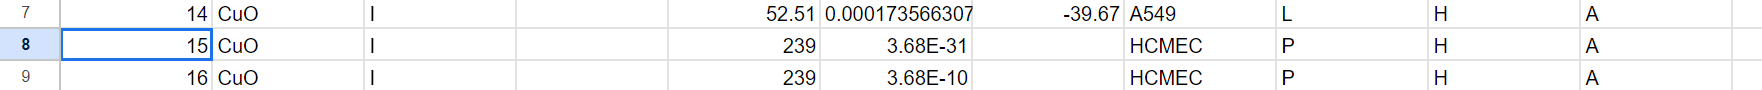

image_2023-06-29_00-40-59.png